In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import sklearn


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, LSTM, Input,SpatialDropout1D, GlobalMaxPool1D, MaxPooling1D, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_score, accuracy_score, recall_score, f1_score
from tensorflow.keras.optimizers import Adam

In [2]:
# 5. Membaca file CSV ke dalam DataFrame
import pandas as pd
df = pd.read_csv('dataset_50k.csv')
df.head()

Unnamed: 0  Label                                         detokenize
0           0      1  aku luka diri aku jalan hidup sulit orang tua ...
1           1      0   buang pikir negatif laku gelisah milik putus asa
2           2      1  jujur aku takut mati aku orang aku sulit paham...
3           3      0              saya mes pasang sepatu jam saya harap
4           4      1  capek hati banget aku allah aku kayak mata ora...

In [3]:
df = df.dropna()
df

Unnamed: 0  Label                                         detokenize
0               0      1  aku luka diri aku jalan hidup sulit orang tua ...
1               1      0   buang pikir negatif laku gelisah milik putus asa
2               2      1  jujur aku takut mati aku orang aku sulit paham...
3               3      0              saya mes pasang sepatu jam saya harap
4               4      1  capek hati banget aku allah aku kayak mata ora...
...           ...    ...                                                ...
50518       50518      0  curi rampok liar begal rakyat senantiasa resah...
50519       50519      0                      saya bicara saya buat tertawa
50520       50520      1  sakit sakit guna sakit bahagia sakit bohong or...
50521       50521      1                              lantai lantai gelisah
50522       50522      1  aku tulis catat kemarin kata tunang aku laku b...

[50523 rows x 3 columns]

In [4]:
df['label'] = df['Label'].apply(lambda x: 0 if x == 0 else 1)
df.head()

Unnamed: 0  Label                                         detokenize  label
0           0      1  aku luka diri aku jalan hidup sulit orang tua ...      1
1           1      0   buang pikir negatif laku gelisah milik putus asa      0
2           2      1  jujur aku takut mati aku orang aku sulit paham...      1
3           3      0              saya mes pasang sepatu jam saya harap      0
4           4      1  capek hati banget aku allah aku kayak mata ora...      1

<BarContainer object of 2 artists>

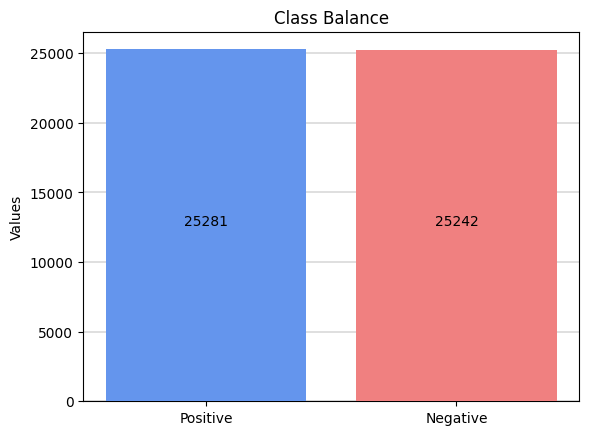

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center',zorder=4)

# Count the values in the 'Label' column
count = df['Label'].value_counts()
x = ["Positive", "Negative"]  # Custom labels for class balance plot
y = [count[1], count[0]]
addlabels(x,y)
plt.ylabel("Values")
plt.title('Class Balance')
plt.grid(color='dimgray', linewidth=0.3, axis='y',zorder=0)
plt.bar(x,y, color= ['cornflowerblue', 'lightcoral'], zorder=3)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vektorisasi teks menggunakan TF-IDF unigram(1,1)
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,1), max_df=0.7, max_features=10000)

# Menggunakan fit_transform untuk mengubah dokumen menjadi fitur
vector = vectorizer.fit_transform(df['detokenize']).toarray()
tf_idf_len = len(vectorizer.vocabulary_)

In [7]:
#Split data 70% data train and 30% data test
x_unigram = pd.DataFrame(vector)
label = df["Label"]
x_train, x_test, y_train, y_test =  model_selection.train_test_split(x_unigram,label, test_size = 0.3)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(35366, 3445) (35366,)
(15157, 3445) (15157,)


In [8]:
y_train

29528    0
46251    0
39258    0
21087    0
13323    1
        ..
29553    1
47342    1
11595    1
29299    0
10595    1
Name: Label, Length: 35366, dtype: int64

In [9]:
x_train = np.array(x_train).reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1], 1)

In [10]:
x_train

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])

In [11]:
x_train.shape

(35366, 3445, 1)

In [12]:
import matplotlib.pyplot as plt

def make_plot(history, train, validation, title):
    graph = plt.plot(history.history[train], lw=2.0)
    graph = plt.plot(history.history[validation], lw=2.0)
    graph = plt.title(title)
    graph = plt.legend(['training', 'validasi'])
    graph = plt.show()

    return graph

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Membuat model cnn-lstm
def hybrid_cnn_lstm(x_train, y_train, x_test, y_test):


    model = Sequential()
    model.add(Input((x_train.shape[1], 1)))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=128,kernel_size=5,activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(LSTM(128,return_sequences = True))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',optimizer=optimizer ,metrics=['accuracy'])
    print(model.summary())

    history = model.fit(x_train, y_train, epochs = 10, validation_data=(x_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)] )

    #Membuat plot garis akurasi
    make_plot(history, "accuracy", "val_accuracy", "Perubahan Akurasi tiap epoch")

    #predict
    predictions = model.predict(x_test)
    print()
    print("Classification Report :")
    print(classification_report(y_test, predictions.round(), digits=6))


    acc_score = accuracy_score(y_test, predictions.round())
    prec_score = precision_score(y_test, predictions.round())
    rec_score = recall_score(y_test, predictions.round())
    f1score = f1_score(y_test, predictions.round())

    return [acc_score,prec_score,rec_score,f1score ]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d (SpatialDropout1D) │ (None, 3445, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 3441, 128)           │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1720, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 220160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │       7,045,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,177,537 (27.38 MB)

 Trainable params: 7,177,537 (27.38 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 98s 83ms/step - accuracy: 0.6838 - loss: 0.5365 - val_accuracy: 0.8059 - val_loss: 0.4000
Epoch 2/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 136s 82ms/step - accuracy: 0.7518 - loss: 0.4324 - val_accuracy: 0.8201 - val_loss: 0.3691
Epoch 3/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 142s 83ms/step - accuracy: 0.7806 - loss: 0.3922 - val_accuracy: 0.8248 - val_loss: 0.3598
Epoch 4/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 142s 83ms/step - accuracy: 0.8008 - loss: 0.3582 - val_accuracy: 0.8200 - val_loss: 0.3678
Epoch 5/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 142s 83ms/step - accuracy: 0.8113 - loss: 0.3359 - val_accuracy: 0.8291 - val_loss: 0.3689
Epoch 6/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 142s 82ms/step - accuracy: 0.8267 - loss: 0.3124 - val_accuracy: 0.8225 - val_loss: 0.3786


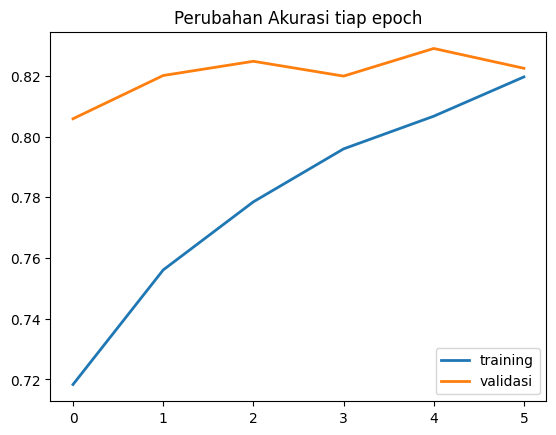

474/474 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.832964  0.802081  0.817231      7498
           1   0.813028  0.842538  0.827520      7659

    accuracy                       0.822524     15157
   macro avg   0.822996  0.822309  0.822375     15157
weighted avg   0.822890  0.822524  0.822430     15157



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d_1                  │ (None, 3445, 1)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 3441, 128)           │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1720, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 220160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │       7,045,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,177,537 (27.38 MB)

 Trainable params: 7,177,537 (27.38 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 103s 91ms/step - accuracy: 0.6930 - loss: 0.5376 - val_accuracy: 0.8113 - val_loss: 0.3890
Epoch 2/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 141s 90ms/step - accuracy: 0.7623 - loss: 0.4284 - val_accuracy: 0.8211 - val_loss: 0.3708
Epoch 3/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 134s 83ms/step - accuracy: 0.7800 - loss: 0.3870 - val_accuracy: 0.8226 - val_loss: 0.3684
Epoch 4/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 142s 84ms/step - accuracy: 0.7942 - loss: 0.3615 - val_accuracy: 0.8237 - val_loss: 0.3633
Epoch 5/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 141s 83ms/step - accuracy: 0.8099 - loss: 0.3366 - val_accuracy: 0.8189 - val_loss: 0.3718
Epoch 6/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 150s 91ms/step - accuracy: 0.8251 - loss: 0.3087 - val_accuracy: 0.8261 - val_loss: 0.3738
Epoch 7/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 133s 83ms/step - accuracy: 0.8349 - loss: 0.2838 - val_accuracy: 0.8221 - val_loss: 0.4060


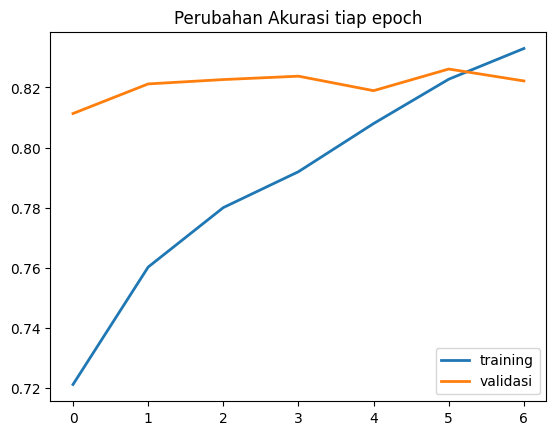

474/474 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.823062  0.815818  0.819424      7498
           1   0.821230  0.828307  0.824753      7659

    accuracy                       0.822128     15157
   macro avg   0.822146  0.822062  0.822088     15157
weighted avg   0.822136  0.822128  0.822117     15157



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d_2                  │ (None, 3445, 1)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 3441, 128)           │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1720, 128)           │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1720, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 220160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │       7,045,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,177,537 (27.38 MB)

 Trainable params: 7,177,537 (27.38 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 95s 84ms/step - accuracy: 0.6846 - loss: 0.5406 - val_accuracy: 0.8085 - val_loss: 0.3943
Epoch 2/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 160s 101ms/step - accuracy: 0.7644 - loss: 0.4220 - val_accuracy: 0.8194 - val_loss: 0.3749
Epoch 3/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 131s 91ms/step - accuracy: 0.7860 - loss: 0.3859 - val_accuracy: 0.8207 - val_loss: 0.3672
Epoch 4/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 133s 83ms/step - accuracy: 0.8004 - loss: 0.3599 - val_accuracy: 0.8284 - val_loss: 0.3664
Epoch 5/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 142s 83ms/step - accuracy: 0.8104 - loss: 0.3326 - val_accuracy: 0.8228 - val_loss: 0.3801
Epoch 6/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 142s 83ms/step - accuracy: 0.8231 - loss: 0.3119 - val_accuracy: 0.8242 - val_loss: 0.3825
Epoch 7/10
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 141s 83ms/step - accuracy: 0.8323 - loss: 0.2880 - val_accuracy: 0.8186 - val_loss: 0.3966


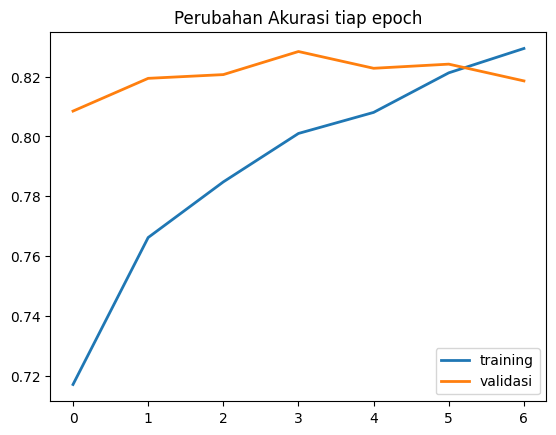

474/474 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.853800  0.764070  0.806447      7498
           1   0.790577  0.871915  0.829256      7659

    accuracy                       0.818566     15157
   macro avg   0.822188  0.817993  0.817852     15157
weighted avg   0.821853  0.818566  0.817973     15157



In [14]:
result = []
result.append(hybrid_cnn_lstm(x_train, y_train, x_test, y_test))
result.append(hybrid_cnn_lstm(x_train, y_train, x_test, y_test))
result.append(hybrid_cnn_lstm(x_train, y_train, x_test, y_test))

In [15]:
average = np.mean(result, axis=0, dtype=float)
print('Average Accuracy  :', average[0])
print('Average Precision :', average[1])
print('Average Recall    :', average[2])
print('Average F1-Score  :', average[3])

Average Accuracy  : 0.8210727716566604
Average Precision : 0.8082779672667875
Average Recall    : 0.8475867171519346
Average F1-Score  : 0.8271763482776816
